In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [180]:
df = pd.read_csv('~/Desktop/titanic_demographics.csv')
df = df.set_index('PassengerId')


dummies = pd.get_dummies(df['Sex'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
dummies = pd.get_dummies(df['Embarked'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)

In [181]:
def Assess(row):
     if row==1:
        return 'survived'
     return 'died'

df_survived = pd.read_csv('~/Desktop/titanic_survived.csv')
df_survived = df_survived.set_index('PassengerId')

df_survived['outcome'] = df_survived.apply(lambda x: Assess(x.Survived), axis=1)

df_survived = df_survived.drop(['Survived'], axis=1)

In [182]:
df_survived.head()

,outcome
PassengerId,
892,died
893,survived
894,died
895,died
896,survived


In [183]:
df = pd.concat([df, df_survived], axis=1)
df = df.dropna()

In [184]:
df

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,outcome
PassengerId,,,,,,,,,
892,3,34.5,0,0,7.8292,1,1,0,died
893,3,47.0,1,0,7.0000,0,0,1,survived
894,2,62.0,0,0,9.6875,1,1,0,died
895,3,27.0,0,0,8.6625,1,0,1,died
896,3,22.0,1,1,12.2875,0,0,1,survived
...,...,...,...,...,...,...,...,...,...
1301,3,3.0,1,1,13.7750,0,0,1,survived
1303,1,37.0,1,0,90.0000,0,1,0,survived
1304,3,28.0,0,0,7.7750,0,0,1,survived


In [185]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['outcome'], random_state = 42)

In [186]:
fn = ['Pclass','Age','Parch','Fare']
cn = ['died', 'survived']

In [187]:
X_train = train[['Pclass','Age','Parch','Fare']]
y_train = train.outcome
X_test = test[['Pclass','Age','Parch','Fare']]
y_test = test.outcome

In [188]:
X_train

,Pclass,Age,Parch,Fare
PassengerId,,,,
998,3,21.00,0,7.8208
1186,3,36.00,0,9.5000
1202,3,18.00,0,8.6625
904,1,23.00,0,82.2667
916,1,48.00,3,262.3750
...,...,...,...,...
1190,1,30.00,0,45.5000
911,3,45.00,0,7.2250
903,1,46.00,0,26.0000


In [189]:
mod_dt = DecisionTreeClassifier(max_depth = 2, random_state = 1)
mod_dt.fit(X_train,y_train)
prediction=mod_dt.predict(X_test)
print("The accuracy of the Decision Tree is","{:.3f}".format(metrics.accuracy_score(prediction,y_test)))

The accuracy of the Decision Tree is 0.642


In [190]:
mod_dt.feature_importances_

array([0.        , 0.48698823, 0.        , 0.51301177])

[Text(279.0, 362.4, 'Fare <= 15.398\ngini = 0.472\nsamples = 264\nvalue = [163, 101]\nclass = died'),
 Text(139.5, 217.44, 'Age <= 23.5\ngini = 0.409\nsamples = 122\nvalue = [87, 35]\nclass = died'),
 Text(69.75, 72.47999999999996, 'gini = 0.477\nsamples = 51\nvalue = [31, 20]\nclass = died'),
 Text(209.25, 72.47999999999996, 'gini = 0.333\nsamples = 71\nvalue = [56, 15]\nclass = died'),
 Text(418.5, 217.44, 'Age <= 36.25\ngini = 0.498\nsamples = 142\nvalue = [76, 66]\nclass = died'),
 Text(348.75, 72.47999999999996, 'gini = 0.497\nsamples = 82\nvalue = [38, 44]\nclass = survived'),
 Text(488.25, 72.47999999999996, 'gini = 0.464\nsamples = 60\nvalue = [38, 22]\nclass = died')]

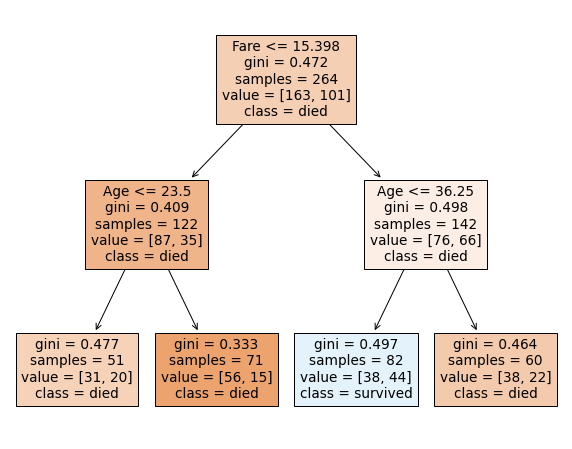

In [191]:
plt.figure(figsize = (10,8))
plot_tree(mod_dt, feature_names = fn, class_names = cn, filled = True)